In [1]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import tensorflow as tf
from sklearn.model_selection import train_test_split
from autokeras import StructuredDataClassifier
from tpot import TPOTClassifier

# Sanity Check and Data Cleaning

In [25]:
# File path for the training dataset
data_file_path = 'data/train.csv'

# Load the training dataset into a DataFrame
training_car_price_df = pd.read_csv(data_file_path)

# Preliminary sanity checks
# 1. Display the first few rows of the dataset to check structure
print("First 5 rows of the dataset:")
print(training_car_price_df.head(), '\n')

# 2. Check for basic information such as column names, data types, and non-null values
print("Basic dataset information:")
training_car_price_df.info()

# 3. Check for missing values in the dataset
print("\nMissing values in each column:")
print(training_car_price_df.isnull().sum())

# 4. Check for duplicated rows
print("\nNumber of duplicated rows:")
print(training_car_price_df.duplicated().sum())

# 5. Get summary statistics for numerical columns (sanity check for outliers or incorrect values)
print("\nSummary statistics of the dataset:")
print(training_car_price_df.describe())

# 6. Check for any obvious outliers or unusual values (e.g., negative prices)
print("\nChecking for rows with negative car prices:")
negative_price_rows = training_car_price_df[training_car_price_df['price'] < 0]
print(negative_price_rows if not negative_price_rows.empty else "No negative car prices found.")

# 7. Check for categorical columns with inconsistent values
if 'brand' in training_car_price_df.columns:
    print("\nUnique values in the 'brand' column:")
    print(training_car_price_df['brand'].unique())

First 5 rows of the dataset:
   id          brand              model  model_year  milage      fuel_type  \
0   0           MINI      Cooper S Base        2007  213000       Gasoline   
1   1        Lincoln              LS V8        2002  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                             A/T  Silver   Beige   
2     

In [5]:
sample_size = 5  # Define how many rows you want to sample

# 1. Inspect sample rows with missing values in 'fuel_type'
print(f"Sample rows with missing 'fuel_type' values:")
missing_fuel_type_df = training_car_price_df[training_car_price_df['fuel_type'].isnull()]
print(missing_fuel_type_df.sample(n=sample_size), '\n')

# 2. Inspect sample rows with missing values in 'accident'
print(f"Sample rows with missing 'accident' values:")
missing_accident_df = training_car_price_df[training_car_price_df['accident'].isnull()]
print(missing_accident_df.sample(n=sample_size), '\n')

# 3. Inspect sample rows with missing values in 'clean_title'
print(f"Sample rows with missing 'clean_title' values:")
missing_clean_title_df = training_car_price_df[training_car_price_df['clean_title'].isnull()]
print(missing_clean_title_df.sample(n=sample_size), '\n')

Sample rows with missing 'fuel_type' values:
          id   brand                    model  model_year  milage fuel_type  \
95626  95626   Tesla            Model X P100D        2019   23250       NaN   
77226  77226   Tesla      Model Y Performance        2022   10400       NaN   
78265  78265   Tesla      Model Y Performance        2019   65852       NaN   
3275    3275   Tesla  Model X Long Range Plus        2021   22000       NaN   
47357  47357  Rivian    R1S Adventure Package        2023    2500       NaN   

                                            engine transmission ext_col  \
95626  518.0HP Electric Motor Electric Fuel System          A/T   Black   
77226  455.0HP Electric Motor Electric Fuel System          A/T   White   
78265  455.0HP Electric Motor Electric Fuel System  1-Speed A/T    Gray   
3275   670.0HP Electric Motor Electric Fuel System          A/T    Gray   
47357  835.0HP Electric Motor Electric Fuel System  1-Speed A/T     Red   

      int_col       accident 

In [26]:
# Drop rows where 'accident' have missing values
cleaned_car_price_df = training_car_price_df.dropna(subset=['accident'])

# Check the shape of the dataset after dropping the rows
print(f"Original dataset shape: {training_car_price_df.shape}")
print(f"Dataset shape after dropping rows with missing 'clean_title' and 'accident': {cleaned_car_price_df.shape}")

# Inspect the first few rows of the cleaned dataset
print("\nFirst 5 rows of the cleaned dataset:")
print(cleaned_car_price_df.head())

Original dataset shape: (188533, 13)
Dataset shape after dropping rows with missing 'clean_title' and 'accident': (186081, 13)

First 5 rows of the cleaned dataset:
   id          brand              model  model_year  milage      fuel_type  \
0   0           MINI      Cooper S Base        2007  213000       Gasoline   
1   1        Lincoln              LS V8        2002  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmis

In [27]:
# List of brands that exclusively produce electric vehicles (EVs)
exclusive_ev_brands = ['Tesla', 'Rivian', 'Lucid', 'Polestar']

# Filter rows where 'fuel_type' is missing in the cleaned dataframe
missing_fuel_type_df_cleaned = cleaned_car_price_df[cleaned_car_price_df['fuel_type'].isnull()]

# Total number of rows with missing 'fuel_type' in the cleaned dataframe
total_missing_fuel_type_cleaned = missing_fuel_type_df_cleaned.shape[0]

# Filter rows where the brand is one of the exclusive EV brands
ev_brand_missing_fuel_type_df_cleaned = missing_fuel_type_df_cleaned[missing_fuel_type_df_cleaned['brand'].isin(exclusive_ev_brands)]

# Count rows with missing 'fuel_type' from exclusive EV brands
ev_brand_missing_count_cleaned = ev_brand_missing_fuel_type_df_cleaned.shape[0]

# Count rows with missing 'fuel_type' from non-EV brands
non_ev_brand_missing_count_cleaned = total_missing_fuel_type_cleaned - ev_brand_missing_count_cleaned

# Calculate percentages
ev_brand_missing_percentage_cleaned = (ev_brand_missing_count_cleaned / total_missing_fuel_type_cleaned) * 100 if total_missing_fuel_type_cleaned > 0 else 0
non_ev_brand_missing_percentage_cleaned = (non_ev_brand_missing_count_cleaned / total_missing_fuel_type_cleaned) * 100 if total_missing_fuel_type_cleaned > 0 else 0

# Output the results
print(f"Total rows with missing 'fuel_type' in cleaned dataset: {total_missing_fuel_type_cleaned}")
print(f"Rows with missing 'fuel_type' from exclusive EV brands: {ev_brand_missing_count_cleaned} ({ev_brand_missing_percentage_cleaned:.2f}%)")
print(f"Rows with missing 'fuel_type' from non-EV brands: {non_ev_brand_missing_count_cleaned} ({non_ev_brand_missing_percentage_cleaned:.2f}%)")

Total rows with missing 'fuel_type' in cleaned dataset: 5014
Rows with missing 'fuel_type' from exclusive EV brands: 3863 (77.04%)
Rows with missing 'fuel_type' from non-EV brands: 1151 (22.96%)


In [28]:
# Filter rows where 'fuel_type' is missing and brand is NOT in the exclusive EV brands
non_ev_brand_missing_fuel_type_df_cleaned = missing_fuel_type_df_cleaned[~missing_fuel_type_df_cleaned['brand'].isin(exclusive_ev_brands)]

# Check the total number of rows to ensure there are enough for sampling
total_non_ev_missing_fuel_type = non_ev_brand_missing_fuel_type_df_cleaned.shape[0]
print(f"Total rows with missing 'fuel_type' from non-EV brands: {total_non_ev_missing_fuel_type}")

# Sample 10 random rows from the non-EV brand missing fuel_type data
sample_size = min(10, total_non_ev_missing_fuel_type)
random_non_ev_sample = non_ev_brand_missing_fuel_type_df_cleaned.sample(n=sample_size)

# Display the sample
print(f"\nRandom sample of {sample_size} rows with missing 'fuel_type' from non-EV brands:")
print(random_non_ev_sample)

Total rows with missing 'fuel_type' from non-EV brands: 1151

Random sample of 10 rows with missing 'fuel_type' from non-EV brands:
            id    brand                   model  model_year  milage fuel_type  \
181546  181546    Volvo     Model Y Performance        2012   63450       NaN   
109335  109335      Kia              Bolt EV LT        2018   45617       NaN   
122757  122757      BMW          M8 Competition        2023    3099       NaN   
165573  165573  Porsche           Model S P100D        2018    8237       NaN   
148281  148281     Ford  F-150 Lightning LARIAT        2019     470       NaN   
87196    87196     Audi         Q7 Premium Plus        2021   73837       NaN   
40337    40337     Ford  F-150 Lightning LARIAT        2022    1750       NaN   
4044      4044      Kia             EV6 GT-Line        2022   20000       NaN   
174151  174151    Karma             Revero Base        2017   68000       NaN   
188462  188462     Ford       Mustang Mach-E GT        202

In [29]:
# Filter rows where 'fuel_type' is missing
missing_fuel_type_df_cleaned = cleaned_car_price_df[cleaned_car_price_df['fuel_type'].isnull()]

# List all unique engine types for cars with missing 'fuel_type'
unique_engines_with_missing_fuel_type = missing_fuel_type_df_cleaned['engine'].unique()

# Display the unique engine types
print(f"Unique engine types for cars with missing 'fuel_type':")
print(unique_engines_with_missing_fuel_type)

Unique engine types for cars with missing 'fuel_type':
['Electric Motor Electric Fuel System'
 '518.0HP Electric Motor Electric Fuel System' 'Dual Motor - Standard'
 '670.0HP Electric Motor Electric Fuel System' 'Electric'
 '455.0HP Electric Motor Electric Fuel System'
 '557.0HP Electric Motor Electric Fuel System'
 '200.0HP Electric Motor Electric Fuel System'
 '425.0HP Electric Motor Electric Fuel System'
 '214.0HP Electric Motor Electric Fuel System'
 '778.0HP Electric Motor Electric Fuel System'
 '835.0HP Electric Motor Electric Fuel System'
 '482.0HP Electric Motor Electric Fuel System'
 '480.0HP Electric Motor Electric Fuel System'
 '362.0HP Electric Motor Electric Fuel System'
 '201.0HP Electric Motor Electric Fuel System'
 '563.0HP Electric Motor Electric Fuel System'
 '271.0HP Electric Motor Electric Fuel System'
 '534.0HP Electric Motor Electric Fuel System'
 '266.0HP Electric Motor Electric Fuel System'
 '355.0HP Electric Motor Electric Fuel System'
 '422.0HP Electric Motor 

In [30]:
# List all unique fuel types in the dataset
unique_fuel_types = cleaned_car_price_df['fuel_type'].unique()

# Display the unique fuel types
print(f"Unique fuel types in the dataset:")
print(unique_fuel_types)

Unique fuel types in the dataset:
['Gasoline' 'E85 Flex Fuel' nan 'Hybrid' 'Diesel' 'Plug-In Hybrid' '–'
 'not supported']


In [31]:
# Filter rows where 'fuel_type' is either missing, '–', or 'not supported'
missing_or_invalid_fuel_type_df = cleaned_car_price_df[
    (cleaned_car_price_df['fuel_type'].isnull()) |
    (cleaned_car_price_df['fuel_type'] == '–') |
    (cleaned_car_price_df['fuel_type'] == 'not supported')
]

# List all unique engine types for cars with missing, '–', or 'not supported' 'fuel_type'
unique_engines_with_invalid_fuel_type = missing_or_invalid_fuel_type_df['engine'].unique()

# Display the unique engine types
print(f"Unique engine types for cars with missing, '–', or 'not supported' 'fuel_type':")
print(unique_engines_with_invalid_fuel_type)

Unique engine types for cars with missing, '–', or 'not supported' 'fuel_type':
['Electric Motor Electric Fuel System'
 '518.0HP Electric Motor Electric Fuel System' 'Dual Motor - Standard'
 '670.0HP Electric Motor Electric Fuel System' 'Electric'
 '455.0HP Electric Motor Electric Fuel System'
 '557.0HP Electric Motor Electric Fuel System'
 '200.0HP Electric Motor Electric Fuel System' '–'
 '425.0HP Electric Motor Electric Fuel System'
 '214.0HP Electric Motor Electric Fuel System'
 '778.0HP Electric Motor Electric Fuel System'
 '835.0HP Electric Motor Electric Fuel System'
 '482.0HP Electric Motor Electric Fuel System'
 '480.0HP Electric Motor Electric Fuel System'
 '362.0HP Electric Motor Electric Fuel System'
 '201.0HP Electric Motor Electric Fuel System'
 '563.0HP Electric Motor Electric Fuel System'
 '271.0HP Electric Motor Electric Fuel System'
 '534.0HP Electric Motor Electric Fuel System'
 '266.0HP Electric Motor Electric Fuel System'
 '140.0HP 1.8L 4 Cylinder Engine Gasoline F

In [32]:
# Filter rows where 'fuel_type' is NOT null, NOT '–', and NOT 'not supported'
valid_fuel_type_df = cleaned_car_price_df[
    cleaned_car_price_df['fuel_type'].notnull() &
    (cleaned_car_price_df['fuel_type'] != '–') &
    (cleaned_car_price_df['fuel_type'] != 'not supported')
]

# Check if any of the rows with valid 'fuel_type' have engine types in 'unique_engines_with_invalid_fuel_type'
rows_with_invalid_engines_but_valid_fuel_type = valid_fuel_type_df[
    valid_fuel_type_df['engine'].isin(unique_engines_with_invalid_fuel_type)
]

# Output the result
print(f"Total rows with valid 'fuel_type' but engines from invalid 'fuel_type' engines list: {rows_with_invalid_engines_but_valid_fuel_type.shape[0]}")
print("\nSample of rows with valid 'fuel_type' but engines from the invalid engine list:")
print(rows_with_invalid_engines_but_valid_fuel_type.sample(n=min(10, rows_with_invalid_engines_but_valid_fuel_type.shape[0])))

Total rows with valid 'fuel_type' but engines from invalid 'fuel_type' engines list: 45835

Sample of rows with valid 'fuel_type' but engines from the invalid engine list:
            id          brand                                    model  \
12317    12317  Mercedes-Benz                              Metris Base   
71982    71982      Chevrolet                             Suburban LTZ   
113967  113967           Ford                                F-150 XLT   
113059  113059           Land               Rover Discovery HSE LUXURY   
36048    36048            Kia                                  Niro EX   
143441  143441           Land              Rover Range Rover Sport HSE   
44819    44819      Chevrolet                        Suburban 1500 LTZ   
179486  179486         Nissan                              Versa 1.8 S   
36042    36042           Ford                                F-150 XLT   
38058    38058          Acura  MDX 3.5L w/Advance & Entertainment Pkgs   

        model

In [33]:
# Create a DataFrame containing rows with valid fuel_type (non-null, non '-', non 'not supported')
valid_fuel_type_df = cleaned_car_price_df[
    cleaned_car_price_df['fuel_type'].notnull() &
    (cleaned_car_price_df['fuel_type'] != '–') &
    (cleaned_car_price_df['fuel_type'] != 'not supported')
]

# Create a DataFrame containing rows with invalid or missing fuel_type (null, '–', or 'not supported')
invalid_fuel_type_df = cleaned_car_price_df[
    cleaned_car_price_df['fuel_type'].isnull() |
    (cleaned_car_price_df['fuel_type'] == '–') |
    (cleaned_car_price_df['fuel_type'] == 'not supported')
]

# Iterate through each row in the invalid_fuel_type_df to find matching engine in valid_fuel_type_df
for idx, row in invalid_fuel_type_df.iterrows():
    # Find if there's a matching engine in valid_fuel_type_df
    matching_row = valid_fuel_type_df[valid_fuel_type_df['engine'] == row['engine']]
    
    if not matching_row.empty:
        # If match is found, update the invalid fuel_type with the valid fuel_type from the matched row
        cleaned_car_price_df.at[idx, 'fuel_type'] = matching_row['fuel_type'].values[0]
    else:
        # If no match is found, set the fuel_type to null
        cleaned_car_price_df.at[idx, 'fuel_type'] = np.nan

# Check if the process worked
print(f"Fuel types after resolving invalid values:")
print(cleaned_car_price_df['fuel_type'].unique())

Fuel types after resolving invalid values:
['Gasoline' 'E85 Flex Fuel' 'Hybrid' 'Diesel' 'Plug-In Hybrid' nan]


In [34]:
# Filter rows where 'fuel_type' is null after the updates
fuel_type_null_df = cleaned_car_price_df[cleaned_car_price_df['fuel_type'].isnull()]

# List the unique engine types for rows with null 'fuel_type'
null_fuel_type_engines = fuel_type_null_df['engine'].unique()

# Display the total number of rows with null 'fuel_type' and their corresponding engine types
print(f"Total rows with null 'fuel_type': {fuel_type_null_df.shape[0]}")
print(f"\nUnique engine types for rows with null 'fuel_type':")
print(null_fuel_type_engines)

Total rows with null 'fuel_type': 60

Unique engine types for rows with null 'fuel_type':
['214.0HP Electric Motor Electric Fuel System'
 '70.0HP 1.0L 3 Cylinder Engine Gasoline Fuel'
 '416.0HP Electric Motor Electric Fuel System'
 '147.0HP Electric Motor Electric Fuel System'
 '111.2Ah / FR 70kW / RR 160kW (697V)'
 '290.0HP Electric Motor Electric Fuel System'
 '111.0HP Electric Motor Electric Fuel System'
 '115.0HP Electric Motor Electric Fuel System']


In [35]:
# Dictionary mapping engine types to their corresponding fuel types
engine_to_fuel_type = {
    '214.0HP Electric Motor Electric Fuel System': 'Full Electric',
    '70.0HP 1.0L 3 Cylinder Engine Gasoline Fuel': 'Gasoline',
    '416.0HP Electric Motor Electric Fuel System': 'Full Electric',
    '147.0HP Electric Motor Electric Fuel System': 'Full Electric',
    '290.0HP Electric Motor Electric Fuel System': 'Full Electric',
    '111.2Ah / FR 70kW / RR 160kW (697V)': 'Full Electric',
    '111.0HP Electric Motor Electric Fuel System': 'Full Electric',
    '115.0HP Electric Motor Electric Fuel System': 'Full Electric'
}

# Update rows where 'fuel_type' is null with the corresponding values from engine_to_fuel_type
for engine, fuel_type in engine_to_fuel_type.items():
    cleaned_car_price_df.loc[
        (cleaned_car_price_df['fuel_type'].isnull()) & (cleaned_car_price_df['engine'] == engine),
        'fuel_type'
    ] = fuel_type

# Check if the process worked by listing the remaining null 'fuel_type' rows
remaining_null_fuel_type_df = cleaned_car_price_df[cleaned_car_price_df['fuel_type'].isnull()]

print(f"Total rows with null 'fuel_type' after update: {remaining_null_fuel_type_df.shape[0]}")

Total rows with null 'fuel_type' after update: 0


c:\Anaconda3\envs\regression_of_used_car_prices_env\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [38]:
# Define a list of pseudo-null values to check for
pseudo_null_values = ['-', ' ', 'not supported', 'N/A', 'NA', '']

# List of columns that are non-numeric and need to be checked
columns_to_check = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']

# Function to check for pseudo-null values in a column
def check_pseudo_nulls(df, columns, pseudo_nulls):
    for column in columns:
        # Check how many times each pseudo-null value appears in the column
        print(f"\nChecking column: {column}")
        for value in pseudo_nulls:
            count = df[df[column] == value].shape[0]
            if count > 0:
                print(f"Found {count} occurrences of '{value}' in {column}")

# Call the function to check for pseudo-null values in the specified columns
check_pseudo_nulls(cleaned_car_price_df, columns_to_check, pseudo_null_values)


Checking column: brand

Checking column: model

Checking column: fuel_type

Checking column: engine

Checking column: transmission

Checking column: ext_col

Checking column: int_col

Checking column: accident

Checking column: clean_title


In [39]:
# Final sanity check for null values in the dataset, ignoring 'clean_title' column
null_values_check = cleaned_car_price_df.drop(columns=['clean_title']).isnull().sum()

# Print the number of null values in each column (excluding 'clean_title')
print("Null values in each column (excluding 'clean_title'):")
print(null_values_check)

# If there are no null values in columns other than 'clean_title', export the cleaned DataFrame
if null_values_check.sum() == 0:
    output_file_path = 'data/clean_train.csv'
    cleaned_car_price_df.to_csv(output_file_path, index=False)
    print(f"\nCleaned data has been successfully exported to {output_file_path}")
else:
    print("\nThere are still some null values in the dataset (excluding 'clean_title'). Please review the data.")

Null values in each column (excluding 'clean_title'):
id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
price           0
dtype: int64

Cleaned data has been successfully exported to data/clean_train.csv


# EDA and Statistical Analysis

Correlation of numerical features with price:
price         1.000000
model_year    0.232943
milage       -0.283954
Name: price, dtype: float64


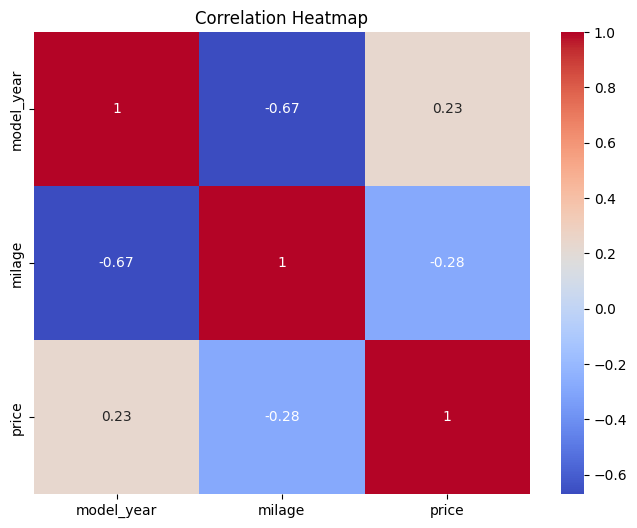

In [40]:
# Select numerical features only (exclude 'id' and 'price')
numerical_features = ['model_year', 'milage']

# Calculate correlation with price
correlation_with_price = cleaned_car_price_df[numerical_features + ['price']].corr()['price'].sort_values(ascending=False)

# Display the correlation
print("Correlation of numerical features with price:")
print(correlation_with_price)

# Visualize the correlation
plt.figure(figsize=(8, 6))
sns.heatmap(cleaned_car_price_df[numerical_features + ['price']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

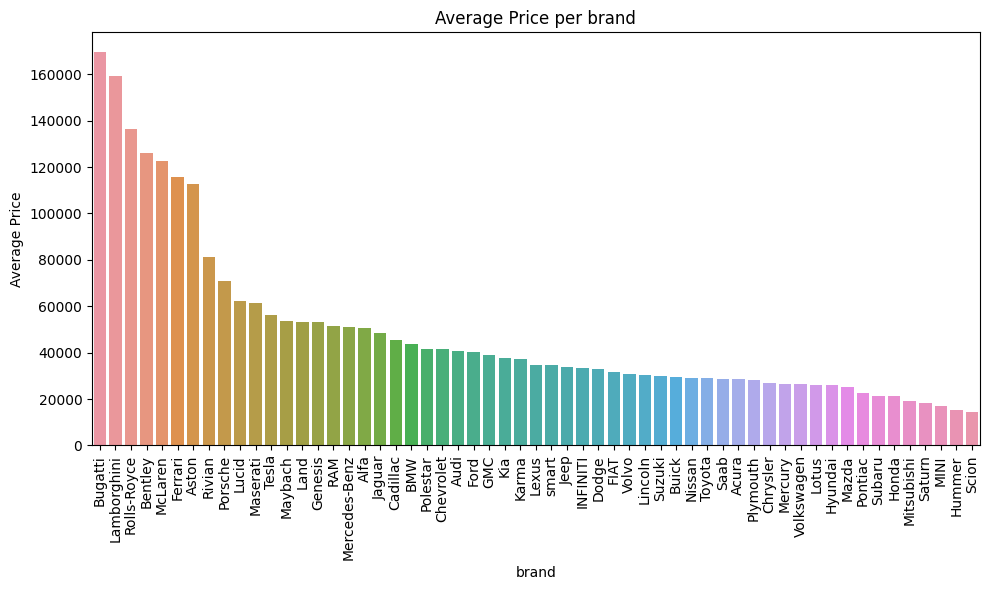

Mean price per brand:
brand
Bugatti          169600.000000
Lamborghini      159255.678436
Rolls-Royce      136564.560579
Bentley          126185.021333
McLaren          122634.219008
Ferrari          115611.255682
Aston            112564.459916
Rivian            81032.357895
Porsche           70701.320584
Lucid             62425.432836
Maserati          61301.029095
Tesla             56406.682960
Maybach           53566.333333
Land              53140.064615
Genesis           53083.461134
RAM               51311.018439
Mercedes-Benz     51135.678489
Alfa              50849.777444
Jaguar            48532.615444
Cadillac          45636.233008
BMW               43555.559655
Polestar          41754.857143
Chevrolet         41742.532899
Audi              40929.824838
Ford              40453.145348
GMC               38835.854839
Kia               37686.966490
Karma             37384.176471
Lexus             34720.026828
smart             34664.000000
Jeep              33877.210184
INFINITI   

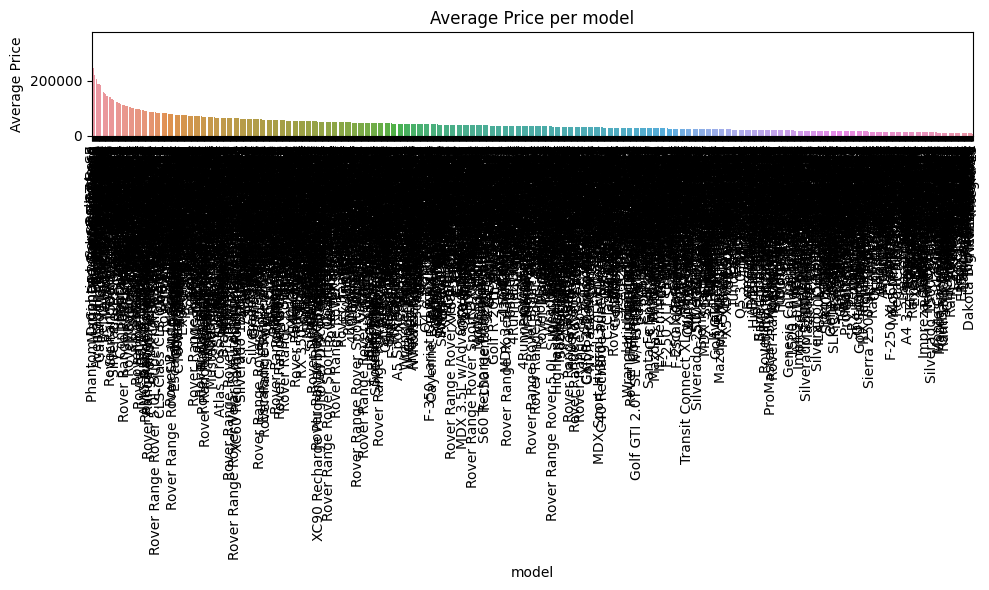

Mean price per model:
model
Carrera GT Base                    356937.250000
Gallardo SE                        265551.272727
Phantom Drophead Coupe Drophead    257656.600000
Continental GT GT Speed            244661.833333
Martin DB7 Vantage Volante         229714.312500
                                       ...      
Ram Van 1500                         8693.772727
Eurovan MV                           8245.571429
Yaris L                              8215.625000
Matrix XR                            7688.000000
Integra LS                           7683.117647
Name: price, Length: 1897, dtype: float64




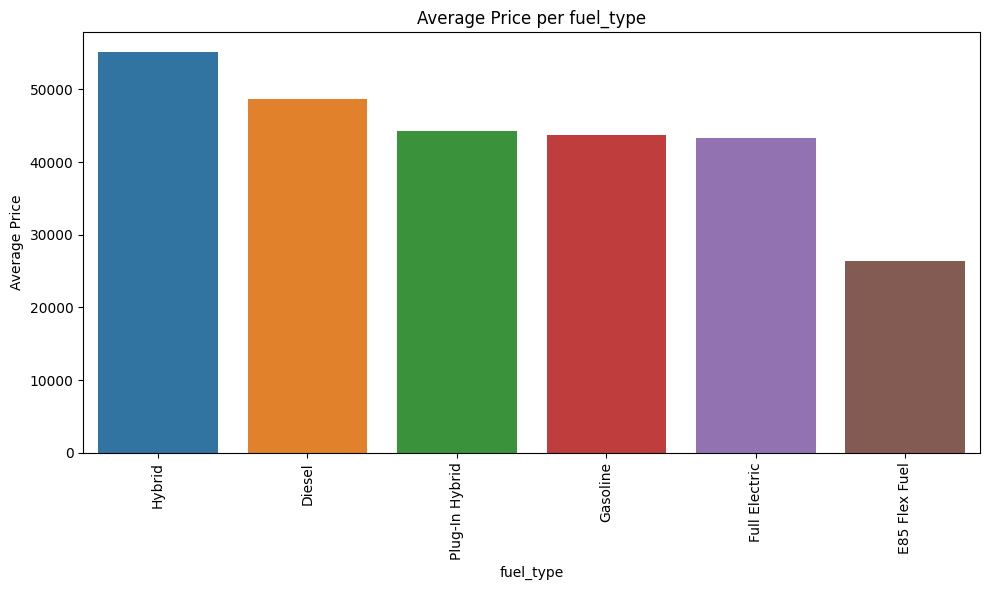

Mean price per fuel_type:
fuel_type
Hybrid            55113.708562
Diesel            48635.531120
Plug-In Hybrid    44319.955684
Gasoline          43700.915946
Full Electric     43331.932203
E85 Flex Fuel     26329.886304
Name: price, dtype: float64




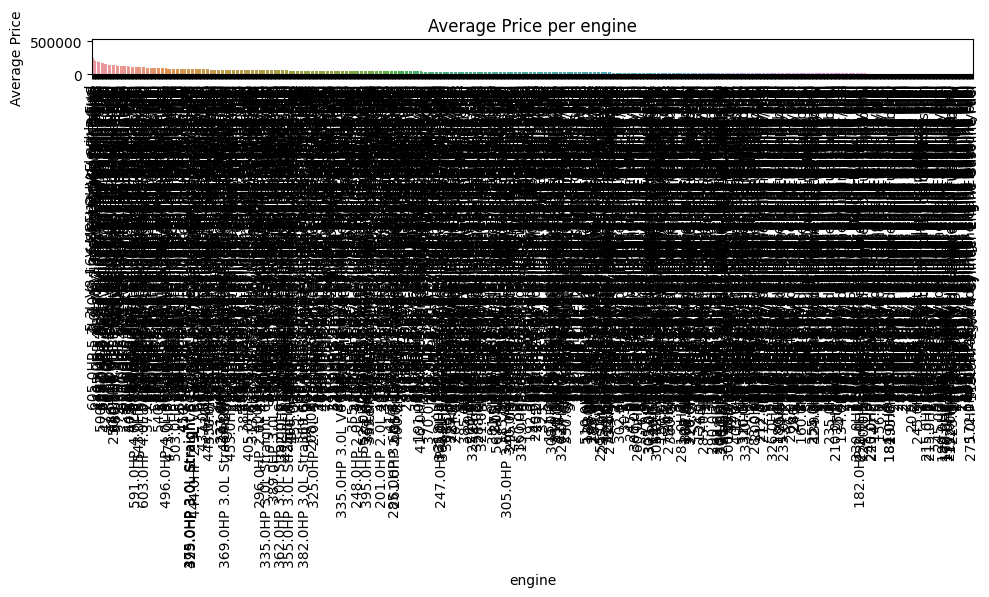

Mean price per engine:
engine
5.3L V8 16V MPFI OHV Flexible Fuel                       505612.166667
6.8L V12 48V GDI DOHC                                    303811.058824
605.0HP 5.7L 10 Cylinder Engine Gasoline Fuel            250087.538462
4.0L H6 24V GDI DOHC                                     222349.120438
12 Cylinder Engine                                       204101.375000
                                                             ...      
78.0HP 1.2L 3 Cylinder Engine Gasoline Fuel                8000.000000
140.0HP 2.8L V6 Cylinder Engine Gasoline Fuel              7805.209302
172.0HP 2.4L 4 Cylinder Engine Gas/Electric Hybrid         7780.833333
275.0HP 4.2L Straight 6 Cylinder Engine Gasoline Fuel      7653.166667
115.0HP 2.0L 4 Cylinder Engine Gasoline Fuel               7379.600000
Name: price, Length: 1116, dtype: float64




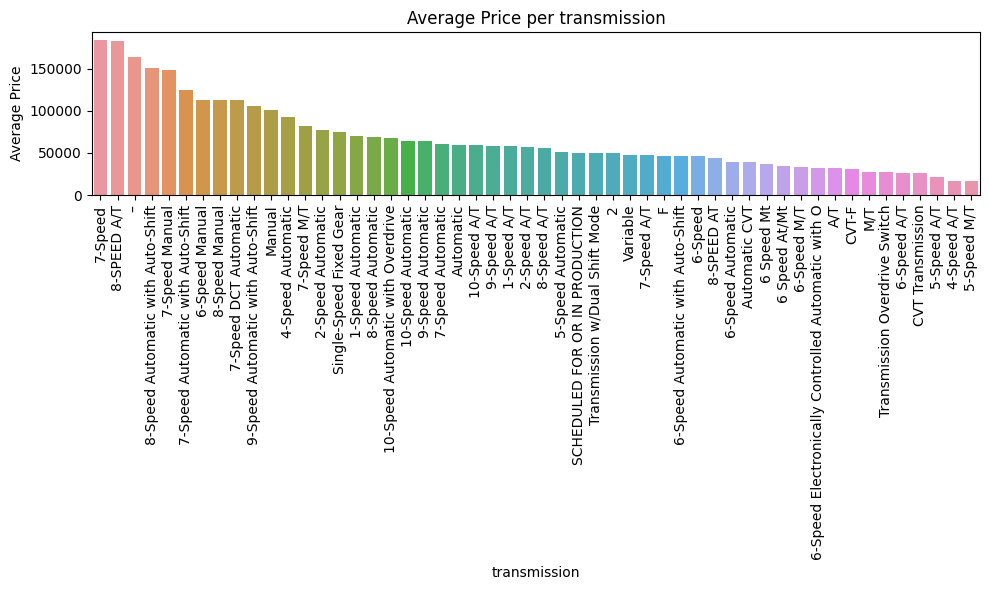

Mean price per transmission:
transmission
7-Speed                                               183672.586207
8-SPEED A/T                                           182691.000000
–                                                     163825.952381
8-Speed Automatic with Auto-Shift                     150402.740260
7-Speed Manual                                        148083.835616
7-Speed Automatic with Auto-Shift                     124417.326707
6-Speed Manual                                        112889.352041
8-Speed Manual                                        112693.928571
7-Speed DCT Automatic                                 112569.444444
9-Speed Automatic with Auto-Shift                     105641.937500
Manual                                                100583.481481
4-Speed Automatic                                      92136.739130
7-Speed M/T                                            82229.827485
2-Speed Automatic                                      77319.545455
Single

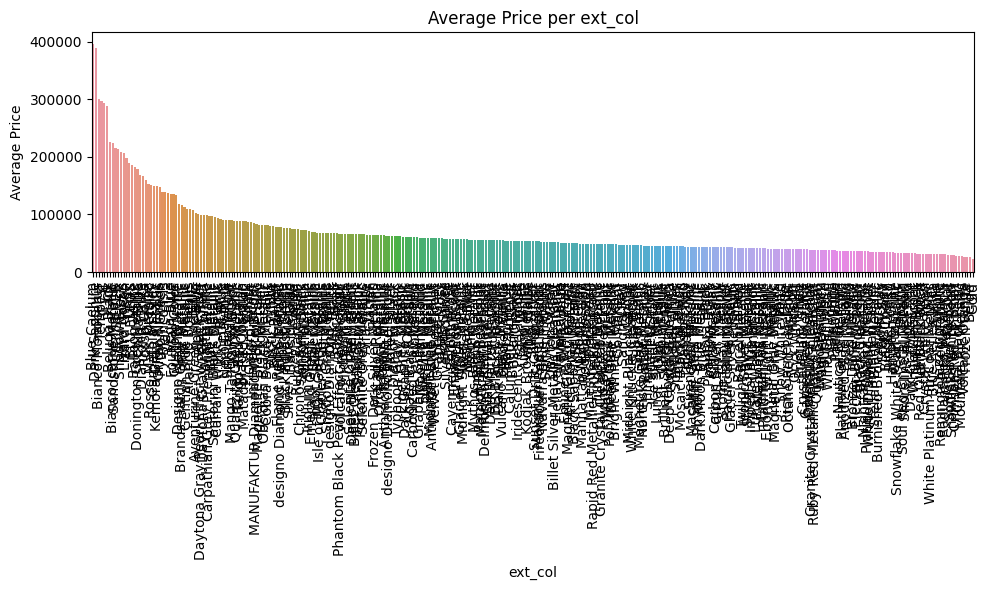

Mean price per ext_col:
ext_col
Blue Caelum              396263.600000
Dark Sapphire            388196.100000
Bianco Monocerus         300063.076923
Tempest                  296988.571429
C / C                    294274.393939
                             ...      
Mountain Air Metallic     28121.000000
Volcanic Orange           26912.000000
Frozen White              25809.000000
Beige                     25503.630496
Gold                      23132.516403
Name: price, Length: 319, dtype: float64




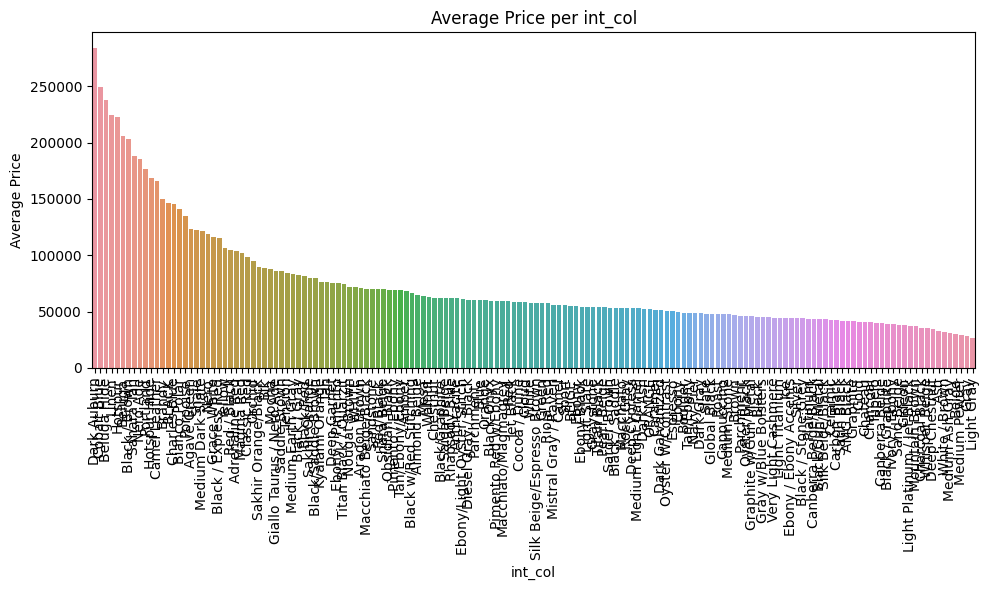

Mean price per int_col:
int_col
Dark Auburn        283712.142857
Cobalt Blue        249600.666667
Beluga Hide        237437.340426
Linen              224166.555556
Hotspur            223075.418605
                       ...      
Medium Ash Gray     31039.727273
Beige               29854.835856
Medium Pewter       29677.894737
Gray                28109.145924
Light Gray          26538.250000
Name: price, Length: 156, dtype: float64




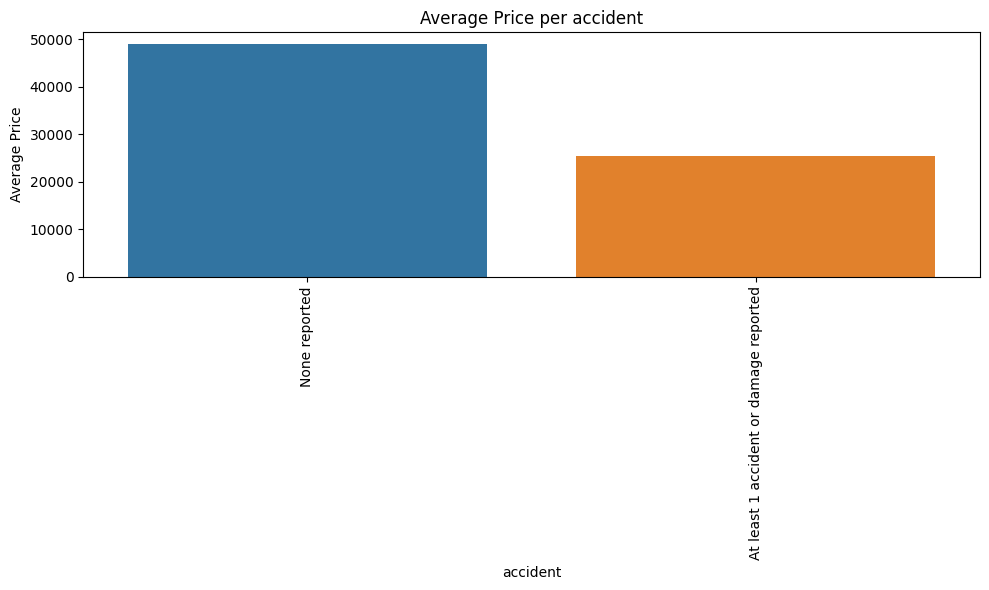

Mean price per accident:
accident
None reported                             49024.804144
At least 1 accident or damage reported    25334.071475
Name: price, dtype: float64




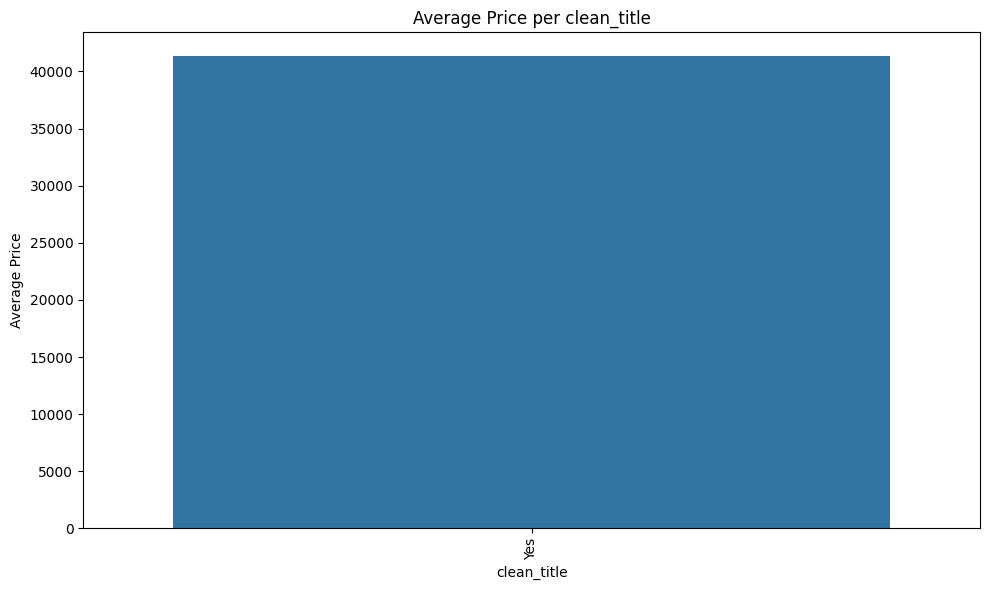

Mean price per clean_title:
clean_title
Yes    41354.380174
Name: price, dtype: float64




In [41]:
# List of categorical features to analyze
categorical_features = ['brand', 'fuel_type', 'transmission', 'accident']

# Loop through each categorical feature to compute the mean price per category
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    
    # Group by the feature and calculate mean price
    mean_price_per_category = cleaned_car_price_df.groupby(feature)['price'].mean().sort_values(ascending=False)
    
    # Plot the mean price per category
    sns.barplot(x=mean_price_per_category.index, y=mean_price_per_category.values)
    plt.xticks(rotation=90)
    plt.title(f'Average Price per {feature}')
    plt.ylabel('Average Price')
    plt.xlabel(feature)
    plt.tight_layout()
    plt.show()
    
    # Display the mean prices in the terminal
    print(f"Mean price per {feature}:")
    print(mean_price_per_category)
    print("\n")

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Exclude 'id' and 'price' as target variable
X = cleaned_car_price_df.drop(columns=['id', 'price'])

# Target variable
y = cleaned_car_price_df['price']

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Fit a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Get feature importance from coefficients
feature_importance = pd.Series(model.coef_, index=X_encoded.columns).sort_values(ascending=False)

# Display feature importance
print("Feature importance based on Linear Regression coefficients:")
print(feature_importance)

Feature importance based on Linear Regression coefficients:
engine_5.3L V8 16V MPFI OHV Flexible Fuel              576652.417899
ext_col_Dark Sapphire                                  295696.956898
engine_405.0HP 4.8L 8 Cylinder Engine Gasoline Fuel    271923.612624
model_Rover LR4 Lux                                    261646.656437
ext_col_Ice                                            186997.225480
                                                           ...      
model_Aventador SVJ Base                              -142825.523570
model_Bentayga W12 Signature                          -147343.196022
model_Continental GTC Base                            -157378.958416
model_Aventador LP700-4                               -167078.669689
engine_111.0HP Electric Motor Electric Fuel System    -175533.200044
Length: 3599, dtype: float64


# Model Creation

In [2]:
# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

cleaned_car_price_df = pd.read_csv('data/clean_train.csv')

# Separate features and target variable
X = cleaned_car_price_df.drop(columns=['id', 'price'])
y = cleaned_car_price_df['price']

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Split into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Normalize the numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# Multilayer Preceptron

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# Build the deep learning model
def build_model(input_shape):
    model = Sequential()
    
    # Input layer
    model.add(Dense(128, input_dim=input_shape, activation='relu'))
    
    # Hidden layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))  # Dropout to prevent overfitting
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(1, activation='linear'))  # Output a single continuous value
    
    # Compile the model with mean squared error loss and Adam optimizer
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])
    
    return model

# Build and summarize the model
input_shape = X_train.shape[1]
model = build_model(input_shape)
model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Evaluate the model using RMSE
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate RMSE for train and test sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 128)               460800    
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 471,169
Trainable params: 471,169
Non-tr

In [7]:
# Multilayer Preceptron

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# Build the deep learning model
def build_model(input_shape):
    model = Sequential()
    
    # Input layer
    model.add(Dense(128, input_dim=input_shape, activation='relu'))
    
    # Hidden layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(1, activation='linear'))  # Output a single continuous value
    
    # Compile the model with mean squared error loss and Adam optimizer
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mse'])
    
    return model

# Build and summarize the model
input_shape = X_train.shape[1]
model = build_model(input_shape)
model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Evaluate the model using RMSE
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate RMSE for train and test sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               460800    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 471,169
Trainable params: 471,169
Non-trai

In [11]:
# Multilayer Preceptron

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# Build the deep learning model
def build_model(input_shape):
    model = Sequential()
    
    # Input layer
    model.add(Dense(128, input_dim=input_shape, activation='relu'))
    
    # Hidden layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(1, activation='linear'))  # Output a single continuous value
    
    # Compile the model with mean squared error loss and Adam optimizer
    model.compile(optimizer=Adam(learning_rate=0.00005), loss='mse', metrics=['mse'])
    
    return model

# Build and summarize the model
input_shape = X_train.shape[1]
model = build_model(input_shape)
model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Evaluate the model using RMSE
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate RMSE for train and test sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               460800    
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 32)                2080      
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                                 
Total params: 471,169
Trainable params: 471,169
Non-tr

In [8]:
# Multilayer Preceptron

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# Build the deep learning model
def build_model(input_shape):
    model = Sequential()
    
    # Input layer
    model.add(Dense(128, input_dim=input_shape, activation='relu'))
    
    # Hidden layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(1, activation='linear'))  # Output a single continuous value
    
    # Compile the model with mean squared error loss and Adam optimizer
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mse'])
    
    return model

# Build and summarize the model
input_shape = X_train.shape[1]
model = build_model(input_shape)
model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64)

# Evaluate the model using RMSE
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate RMSE for train and test sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               460800    
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)               

In [9]:
# Multilayer Preceptron

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# Build the deep learning model
def build_model(input_shape):
    model = Sequential()
    
    # Input layer
    model.add(Dense(128, input_dim=input_shape, activation='relu'))
    
    # Hidden layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(1, activation='linear'))  # Output a single continuous value
    
    # Compile the model with mean squared error loss and Adam optimizer
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mse'])
    
    return model

# Build and summarize the model
input_shape = X_train.shape[1]
model = build_model(input_shape)
model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16)

# Evaluate the model using RMSE
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate RMSE for train and test sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               460800    
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dropout_7 (Dropout)         (None, 32)               

In [13]:
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from joblib import parallel_backend  # Import for controlling parallel execution
import numpy as np  # Import for numerical operations

# Custom scorer for RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Separate features and target variable
X = cleaned_car_price_df.drop(columns=['id', 'price'])
y = cleaned_car_price_df['price']

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Split into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Normalize the numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define and fit the TPOT Regressor, optimizing for RMSE
tpot = TPOTRegressor(
    generations=3,  # Reduced the number of generations to lower complexity
    population_size=20,  # Number of models to try in each generation
    verbosity=2,  # Show progress of the process
    scoring=rmse_scorer,  # Use RMSE as the scoring function
    n_jobs=1  # Restrict to 1 core to prevent parallelization issues
)

# Use parallel_backend to manage parallelism with 'loky' backend
with parallel_backend('loky', n_jobs=1):  # Restrict to 1 job for stability
    # Train TPOT model
    tpot.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = tpot.predict(X_test)

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {test_rmse}")

# Export the best pipeline as Python code
tpot.export('tpot_best_pipeline.py')

Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Optimization Progress:   0%|          | 0/80 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -73488.37141080803

Generation 2 - Current best internal CV score: -73488.37141080803

Generation 3 - Current best internal CV score: -73488.37141080803

Best pipeline: DecisionTreeRegressor(input_matrix, max_depth=9, min_samples_leaf=18, min_samples_split=20)
Test RMSE: 76072.1273536513


In [15]:
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np
from joblib import parallel_backend

# Custom scorer for RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Separate features and target variable
X = cleaned_car_price_df.drop(columns=['id', 'price'])
y = cleaned_car_price_df['price']

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Split into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Normalize the numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Desired RMSE target
rmse_target = 71700

# Define TPOT Regressor parameters
tpot = TPOTRegressor(
    generations=5,  # Number of iterations for finding the best model
    population_size=20,  # Number of models to try in each generation
    verbosity=2,  # Show progress of the process
    scoring=rmse_scorer,  # Use RMSE as the scoring function
    n_jobs=1  # Limit to 1 core to prevent parallelization issues
)

# Function to monitor progress and stop if target RMSE is achieved
def check_rmse_progress(tpot, X_test, y_test, rmse_target):
    # Evaluate the model on the test set after each generation
    y_pred = tpot.predict(X_test)
    current_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Current RMSE: {current_rmse}")
    
    # Stop if RMSE is below target
    if current_rmse <= rmse_target:
        print(f"Target RMSE of {rmse_target} reached. Stopping early.")
        return True
    return False

# Use parallel_backend to manage parallelism with 'loky' backend
with parallel_backend('loky', n_jobs=1):  # Restrict to 1 job for stability
    # Train TPOT model
    tpot.fit(X_train, y_train)
    
    # Check progress after fitting
    check_rmse_progress(tpot, X_test, y_test, rmse_target)

# Export the best pipeline as Python code
tpot.export('tpot_best_pipeline.py')

# Final RMSE on test set
y_pred = tpot.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Final RMSE: {final_rmse}")


Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]

: 

# Feature Engineering

In [2]:
import pandas as pd
import numpy as np

cleaned_car_price_df = pd.read_csv('data/clean_train.csv')

# Function to perform feature engineering and drop pre-transformed columns (except clean_title)
def feature_engineering(car_price_df):
    # Create a copy of the dataframe to avoid modifying the original
    car_price_transformed_df = car_price_df.copy()

    # 1. Replace null values in 'clean_title' with 'Unknown'
    car_price_transformed_df['clean_title'] = car_price_transformed_df['clean_title'].fillna('Unknown')

    # 2. Categorize brands into Exotic, Luxury, and Economy
    def categorize_brand(brand):
        exotic_brands = ['Ferrari', 'Lamborghini', 'Bugatti', 'McLaren', 'Aston', 'Rolls-Royce', 'Bentley']
        luxury_brands = ['Porsche', 'Mercedes-Benz', 'Tesla', 'BMW', 'Jaguar', 'Land', 'Maserati', 'Lucid',
                         'Maybach', 'Alfa', 'Lexus', 'Cadillac', 'Genesis', 'Rivian', 'Audi', 'Polestar', 'INFINITI']
        economy_brands = ['Ford', 'Chevrolet', 'Honda', 'Toyota', 'Volkswagen', 'Hyundai', 'Mazda', 'Subaru', 
                          'Kia', 'Nissan', 'Chrysler', 'Jeep', 'RAM', 'GMC', 'Dodge', 'Buick', 'FIAT', 'Lincoln',
                          'Mitsubishi', 'Pontiac', 'Saturn', 'Acura', 'Scion', 'smart', 'Karma', 'Plymouth', 
                          'Suzuki', 'Saab', 'Mercury', 'MINI', 'Hummer', 'Volvo']
        
        if brand in exotic_brands:
            return 'Exotic'
        elif brand in luxury_brands:
            return 'Luxury'
        else:
            return 'Economy'
    
    car_price_transformed_df['brand_category'] = car_price_transformed_df['brand'].apply(categorize_brand)

    # 3. Generalize engines by cylinder count and horsepower
    def generalize_engine(engine, fuel_type):
        if fuel_type in ['Gasoline', 'Diesel', 'E85 Flex Fuel']:
            if 'V6' in engine or 'I6' in engine or '6 Cylinder' in engine:
                return '6 Cylinder'
            elif 'V8' in engine or 'I8' in engine or '8 Cylinder' in engine:
                return '8 Cylinder'
            elif 'V4' in engine or 'I4' in engine or '4 Cylinder' in engine:
                return '4 Cylinder'
            elif 'V10' in engine or 'I10' in engine or '10 Cylinder' in engine:
                return '10 Cylinder'
            elif 'V12' in engine or 'W12' in engine or '12 Cylinder' in engine:
                return '12 Cylinder'
            else:
                return 'Unknown'
        elif fuel_type in ['Hybrid', 'Plug-In Hybrid']:
            return 'Hybrid'
        elif fuel_type == 'Full Electric':
            try:
                hp_value = int(engine.split('HP')[0].strip())
                return f'{hp_value} HP Electric'
            except ValueError:
                return 'Electric Unknown HP'
        else:
            return 'Unknown'

    # If fuel_type is null, infer from engine if it's electric or something else
    car_price_transformed_df['fuel_type'] = car_price_transformed_df.apply(
        lambda row: 'Full Electric' if 'Electric' in row['engine'] and pd.isnull(row['fuel_type']) else row['fuel_type'], axis=1
    )

    car_price_transformed_df['generalized_engine'] = car_price_transformed_df.apply(
        lambda row: generalize_engine(row['engine'], row['fuel_type']), axis=1
    )

    # 4. Calculate car age from model year
    current_year = pd.Timestamp.now().year
    car_price_transformed_df['car_age'] = current_year - car_price_transformed_df['model_year']

    # Drop the original columns that were transformed, except 'clean_title'
    car_price_transformed_df = car_price_transformed_df.drop(columns=['brand', 'engine', 'model_year'])

    return car_price_transformed_df

# Engineered Training Data
engineered_car_price_df = feature_engineering(cleaned_car_price_df)

# Check the resulting DataFrame
engineered_car_price_df.head()

,id,model,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,brand_category,generalized_engine,car_age
0,0,Cooper S Base,213000,Gasoline,A/T,Yellow,Gray,None reported,Yes,4200,Economy,4 Cylinder,17
1,1,LS V8,143250,Gasoline,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,Economy,8 Cylinder,22
2,2,Silverado 2500 LT,136731,E85 Flex Fuel,A/T,Blue,Gray,None reported,Yes,13900,Economy,8 Cylinder,22
3,3,G90 5.0 Ultimate,19500,Gasoline,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,Luxury,8 Cylinder,7
4,4,Metris Base,7388,Gasoline,7-Speed A/T,Black,Beige,None reported,Yes,97500,Luxury,4 Cylinder,3


In [3]:
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from joblib import parallel_backend  # Import for controlling parallel execution
import numpy as np  # Import for numerical operations

# Custom scorer for RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Separate features and target variable
X = engineered_car_price_df.drop(columns=['id', 'price'])
y = engineered_car_price_df['price']

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Split into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Normalize the numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define and fit the TPOT Regressor, optimizing for RMSE
tpot = TPOTRegressor(
    generations=3,  # Reduced the number of generations to lower complexity
    population_size=20,  # Number of models to try in each generation
    verbosity=2,  # Show progress of the process
    scoring=rmse_scorer,  # Use RMSE as the scoring function
    n_jobs=1  # Restrict to 1 core to prevent parallelization issues
)

# Use parallel_backend to manage parallelism with 'loky' backend
with parallel_backend('loky', n_jobs=1):  # Restrict to 1 job for stability
    # Train TPOT model
    tpot.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = tpot.predict(X_test)

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {test_rmse}")

# Export the best pipeline as Python code
tpot.export('tpot_best_pipeline.py')

Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Optimization Progress:   0%|          | 0/80 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -72790.44400550093

Generation 2 - Current best internal CV score: -72790.44400550093

Generation 3 - Current best internal CV score: -72402.85215355639

Best pipeline: LinearSVR(MinMaxScaler(input_matrix), C=0.01, dual=False, epsilon=0.1, loss=squared_epsilon_insensitive, tol=0.0001)
Test RMSE: 75169.68741507894


In [4]:
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from joblib import parallel_backend  # Import for controlling parallel execution
import numpy as np  # Import for numerical operations

# Custom scorer for RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Separate features and target variable
X = engineered_car_price_df.drop(columns=['id', 'price'])
y = engineered_car_price_df['price']

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Split into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Normalize the numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Custom TPOT configuration for feature selection and models
tpot_config = {
    'sklearn.feature_selection.SelectKBest': {
        'k': [5, 10, 20, 'all'],  # Number of top features to select
    },
    'sklearn.feature_selection.VarianceThreshold': {
        'threshold': [0.01, 0.05, 0.1],
    },
    'sklearn.decomposition.PCA': {
        'n_components': [0.95, 0.9, 0.85],  # PCA for dimensionality reduction
    },
    'sklearn.feature_selection.RFE': {
        'n_features_to_select': [5, 10, 20],
    },
    'sklearn.ensemble.RandomForestRegressor': {
        'n_estimators': [100, 200],
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_split': [2, 4],
        'min_samples_leaf': [1, 2],
    },
    'sklearn.linear_model.LinearRegression': {},
    'xgboost.XGBRegressor': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
    }
}

# Define and fit the TPOT Regressor with the custom configuration
tpot = TPOTRegressor(
    generations=10,  # Number of generations for pipeline search
    population_size=50,  # Number of models to try in each generation
    verbosity=2,  # Show progress of the process
    scoring=rmse_scorer,  # Use RMSE as the scoring function
    n_jobs=1,  # Restrict to 1 core to prevent parallelization issues
    config_dict=tpot_config  # Use the custom config for feature selection
)

# Use parallel_backend to manage parallelism with 'loky' backend
with parallel_backend('loky', n_jobs=1):  # Restrict to 1 job for stability
    # Train TPOT model
    tpot.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = tpot.predict(X_test)

# Calculate RMSE for the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {test_rmse}")

# Export the best pipeline as Python code
tpot.export('tpot_best_pipeline_with_feature_selection.py')


Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Optimization Progress:   0%|          | 0/550 [00:00<?, ?pipeline/s]